In [1]:
# pip install -e git+git://github.com/sensiblecodeio/databaker.git@solo-cleaned#egg=databaker

import xlutils
import xypath
import databaker

import databaker.constants
from databaker.constants import *
import databaker.databakersolo as ds
Dcelllookup = ds.overrides.Dcelllookup
batchcelllookup = ds.overrides.batchcelllookup


In [2]:
tableset = xypath.loader.table_set("rftmatables_tcm77-415727.xls", extension='xls')
tabs = list(xypath.loader.get_sheets(tableset, "*"))   

conversionsegments = [ ]
for tab in tabs:
    if tab.name == "Table 1":
        anchor = tab.excel_ref('B3')
        obs = anchor.shift(0, 5).fill(RIGHT).expand(DOWN).is_not_blank()

        unwanted = tab.filter(contains_string ('indicates earliest revision')).expand(RIGHT).expand(DOWN)      
        unwanted = unwanted | tab.excel_ref('V1').expand(RIGHT).expand(DOWN)
        unwanted = unwanted | tab.filter(contains_string ('Number')).shift(RIGHT).fill(DOWN)
        unwanted = unwanted | tab.filter(contains_string ('Value')).shift(RIGHT).fill(DOWN)
        obs = obs - unwanted       

        dimensions = [
            (anchor.expand(DOWN).is_not_blank().is_not_bold(), TIME, DIRECTLY, LEFT),
            (anchor.expand(RIGHT).parent().is_not_blank(), 'Companies', CLOSEST, LEFT),
            (anchor.shift(0, 2).expand(RIGHT).parent().is_not_blank(), MEASURETYPE, CLOSEST, LEFT),
            (anchor.shift(DOWN).expand(RIGHT).parent().is_not_blank(), 'Transaction', CLOSEST, LEFT),
            (anchor.expand(DOWN).is_not_blank().is_bold(), 'TIMETYPE', CLOSEST, ABOVE)   
        ]
        conversionsegments.append((tab, dimensions, obs))
        
    elif tab.name in ['Table 2', 'Table 3', 'Table 4', 'Table 5']:
        anchor = tab.excel_ref('B3')
        obs = anchor.shift(0, 5).fill(RIGHT).expand(DOWN).is_not_blank()

        unwanted = tab.filter(contains_string ('indicates earliest revision')).expand(RIGHT).expand(DOWN)      
        unwanted = unwanted | tab.excel_ref('V1').expand(RIGHT).expand(DOWN)
        unwanted = unwanted | tab.filter(contains_string ('Number')).shift(RIGHT).fill(DOWN)
        unwanted = unwanted | tab.filter(contains_string ('Value')).shift(RIGHT).fill(DOWN)
        obs = obs - unwanted       

        inv1 = anchor.shift(DOWN).expand(RIGHT).parent().is_not_blank()
        inv1 = inv1 | tab.excel_ref('B4')
        inv1.dimension('Investment', CLOSEST, LEFT)

        dimensions = [
            (anchor.expand(DOWN).is_not_blank().is_not_bold(), TIME, DIRECTLY, LEFT),
            (anchor.expand(RIGHT).parent().is_not_blank(), 'Category', CLOSEST, LEFT), 
            (inv1, 'Investment', CLOSEST, LEFT), 
            (anchor.shift(0, 2).expand(RIGHT).parent().is_not_blank(), MEASURETYPE, CLOSEST, LEFT), 
            (tab.excel_ref('C1'), 'Category', CLOSEST, ABOVE), 
            (anchor.shift(0, 2).expand(RIGHT).parent().is_not_blank(), "Measure", CLOSEST, LEFT)
        ]
        conversionsegments.append((tab, dimensions, obs))

    elif tab.name in ["Table 6", "Table 7"]:
        
        my_dict = {"6A_Top": 'CBAQ', "6A_Bottom": 'HCL3', "6D_Top": 'CBAS', "6D_Bottom":'HCL5',
                   "7A_Top": 'CBAU', "7A_Bottom": 'HCK7', "7D_Top": 'CBAW', "7D_Bottom":'HCK9'  }
        for P1, corner in my_dict.items():
            if P1[0] != tab.name[-1]:
                continue
    
            anchor = tab.filter(contains_string(corner))
            obs = anchor.shift(DOWN).expand(RIGHT).expand(DOWN).is_not_blank()

            # Getting all the junk out of the file
            unwanted = tab.excel_ref('AA1').expand(DOWN).expand(RIGHT)     
            unwanted = unwanted | anchor.expand(DOWN).filter(contains_string ('Area Analysis')).expand(RIGHT).expand(DOWN)
            unwanted = unwanted | tab.filter(contains_string ('indicates earliest revision')).expand(RIGHT).expand(DOWN)
            unwanted = unwanted | anchor.expand(DOWN).filter(contains_string ('Number')).shift(UP).expand(RIGHT).expand(DOWN)
            obs = obs - unwanted    
            cat = tab.filter(contains_string(P1[0:2])).shift(RIGHT)
            dimensions = [
                (anchor.shift(0, -2).expand(RIGHT).is_not_blank(), "Area", CLOSEST, LEFT), 
                (anchor.shift(0, -1).expand(RIGHT).is_not_blank(), MEASURETYPE, DIRECTLY, ABOVE), 
                (anchor.shift(-1, 0).expand(DOWN).is_not_blank(), TIME, DIRECTLY, LEFT),
                (cat, "Mergers", CLOSEST, ABOVE)
            ]
            conversionsegments.append((tab, dimensions, obs))

    elif tab.name in ["Table 8", "Table 10"]:
        anchor = tab.excel_ref('C3')
        
        obs = anchor.shift(0, 2).fill(DOWN).expand(RIGHT).is_not_blank()
        obs = obs - tab.excel_ref('R1').expand(DOWN).expand(RIGHT)
        obs = obs - tab.filter(contains_string ('indicates earliest revision')).expand(RIGHT).expand(DOWN)
        measure_line = anchor.shift(DOWN).expand(RIGHT).is_not_blank()
        obs = obs - measure_line.shift(RIGHT).expand(DOWN)
        
        dimensions = [
            (anchor.expand(RIGHT).is_not_blank(), "Category", CLOSEST, LEFT), 
            (measure_line, MEASURETYPE, DIRECTLY, ABOVE), 
            (anchor.shift(LEFT).expand(DOWN).is_bold(), "TIME - DELETEME", CLOSEST, ABOVE), 
            (anchor.shift(LEFT).expand(DOWN).is_not_bold().is_not_blank(), TIME, DIRECTLY, LEFT)
        ]
        conversionsegments.append((tab, dimensions, obs))
    
    elif tab.name in ["Table 9"]:
        anchor = tab.filter(contains_string ('Total')).assert_one()

        dimensions = [ 
            (anchor.shift(0, -2).expand(RIGHT).is_not_blank(), "Expenditure", CLOSEST, LEFT), 
            
            # this is the one gives the word "cash" and might want to be left or right above, although this is unsatisfactory
            # might be better to be able to displace it to the right (provide an offset) which we can then do CLOSEST RIGHT on
            (anchor.shift(0, -1).expand(RIGHT).is_not_blank(), "Expenditure 1", CLOSEST, LEFT),  
            
            (anchor.expand(RIGHT).is_not_blank(), "Expenditure 2", CLOSEST, LEFT), 
            (anchor.shift(LEFT).expand(DOWN).is_not_blank(), TIME, DIRECTLY, LEFT), 
            (anchor.shift(LEFT).expand(DOWN).is_bold(), "ExtraTime", CLOSEST, ABOVE), 
        ]
        # Get obs,and get rid of lots of crap    
        obs = anchor.shift(0, 2).fill(DOWN).expand(RIGHT).is_not_blank()
        obs = obs - tab.excel_ref("V1").expand(DOWN).expand(RIGHT)
        obs = obs - tab.filter(contains_string ("earliest revision")).expand(RIGHT).expand(DOWN)
        obs = obs - anchor.expand(RIGHT).is_not_blank().shift(RIGHT).fill(DOWN)
        conversionsegments.append((tab, dimensions, obs))

            
print("There are %d conversion segments" % len(conversionsegments))
print([c[0].name for c in conversionsegments])

got header Investment: 1.006s,  1.006s total
got header Investment: 0.021s,  1.028s total
got header Investment: 0.019s,  1.046s total
got header Investment: 0.018s,  1.064s total
There are 16 conversion segments
['Table 1', 'Table 2', 'Table 3', 'Table 4', 'Table 5', 'Table 6', 'Table 6', 'Table 6', 'Table 6', 'Table 7', 'Table 7', 'Table 7', 'Table 7', 'Table 8', 'Table 9', 'Table 10']


In [7]:
# Preview a conversion segment inline or on second screen 
from databaker.jupybakeutils import dsubsets, tabletohtml, sidewindowhtmldisplay, inlinehtmldisplay, incrementdividNUM

# this is the segment we will preview
conversionsegment = conversionsegments[9]


tab, dimensions, segment = conversionsegment
htmtable = tabletohtml(tab, dsubsets(dimensions, segment))
incrementdividNUM()
inlinehtmldisplay(htmtable, hide=False)
#sidewindowhtmldisplay()


1

In [14]:
allvalues = [ ]

def procbatch(dimvalue, dimlabel):
    if dimlabel == TIME:
        res = [ ]
        for c in dimvalue:
            if c.value == "2010²":
                res.append(2010)
            else:
                res.append(c.value)
        return res
    return [ c.value if c is not None else "" for c in dimvalue ]  # "2010²"

for tab, dimensions, segment in conversionsegments:
    obslist = list(segment.unordered_cells)  # list(segment) otherwise gives bags of one element
    dimvalues = [ procbatch(batchcelllookup(tab, obslist, dimension), dimension[1])  for dimension in dimensions ]
    dtuples = zip(*([procbatch(obslist, OBS)]+dimvalues))
    keys = [OBS] + [ dimension[1]  for dimension in dimensions ]  # the labels
    dvalues = [ dict(zip(keys, dtup))  for dtup in dtuples  if not isinstance(dtup[0], str) ]
    allvalues.extend(dvalues)
    
"""
# convert the segments and handle the messy cases, eg 2010^2 and missing values
allvalues = [ ]
for tab, dimensions, segment in conversionsegments:
    print(tab.name, [d[1]  for d in dimensions])
    for ob in segment:
        v = { OBS:ob.value }
        for header_bag, name, strict, direction in dimensions:
            try:
                v[name] = ds.overrides.Dcelllookup(header_bag, direction, strict, None, ob).value
            except xypath.NoLookupError:
                v[name] = None
                #print("no lookup", header_bag, ob)
        if isinstance(v[TIME], str):
            v[TIME] = int(v[TIME][:4])
        if isinstance(v[OBS], str):
            continue
        allvalues.append(v)
"""
# In theory we can now call the template export to big CSV, like before at this point
# But now we should seek to plot the stats ourselves as a sanity check that the data is good
        

len(allvalues), allvalues[-1]
#conversionsegments[9][1]


(1955,
 {-6: 'Number',
  'Category': 'Net Transactions in the UK by Foreign Companies¹',
  -2: '2014 Q4',
  'TIME - DELETEME': 'Quarterly',
  -9: 22.0})

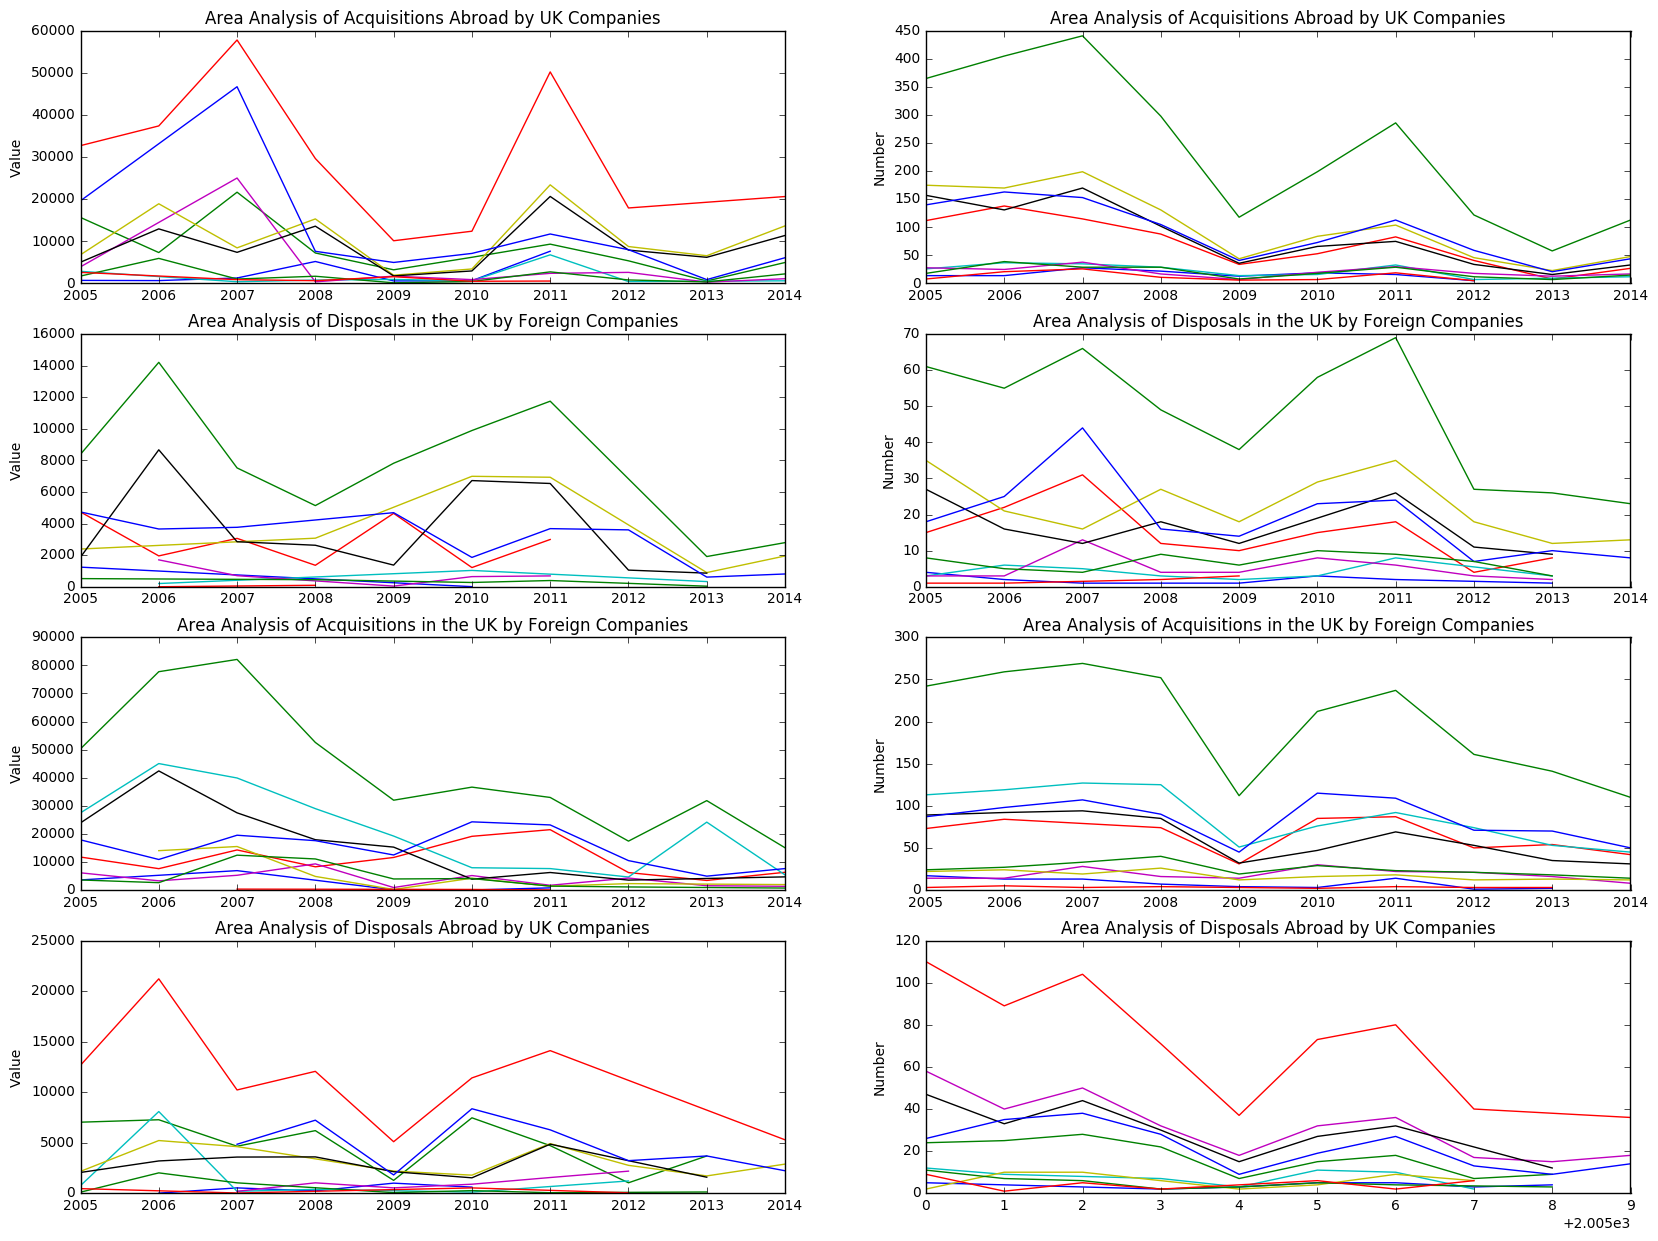

In [17]:
%matplotlib inline

import matplotlib.pyplot as plt
plt.figure(figsize=(20, 15))

mallvalues = [v  for v in allvalues  if v.get("Mergers")]
MEASURETYPEset = set(v[MEASURETYPE]  for v in mallvalues)
mergerset = set(v["Mergers"]  for v in mallvalues)

for i, merger in enumerate(mergerset):
    for j, sMEASURETYPE in enumerate(MEASURETYPEset):
        values = [v  for v in mallvalues  if (v["Mergers"] == merger and v[MEASURETYPE] == sMEASURETYPE) ]
        areas = set(v['Area']  for v in values)

        ax = plt.gca()
        ax.get_xaxis().get_major_formatter().set_useOffset(False)
        #ax.get_xaxis().get_major_formatter().set_scientific(False)

        plt.subplot(len(mergerset), len(MEASURETYPEset), i*len(MEASURETYPEset)+j+1)
        def pairplot(plt, vp, label):
            vp.sort()
            plt.plot([v[0] for v in vp], [v[1] for v in vp], label=label)
        for area in areas:
            pairplot(plt, [(v[TIME], v[OBS])  for v in values  if v["Area"] == area and v[MEASURETYPE] == sMEASURETYPE], area)
        #plt.legend()
        #print(merger, sMEASURETYPE, [(v[TIME], v[OBS])  for v in values  if v["Area"] == area and v[MEASURETYPE] == "Value"])
        #break
        plt.title(values[0]["Mergers"])
        plt.ylabel(sMEASURETYPE)
plt.show()


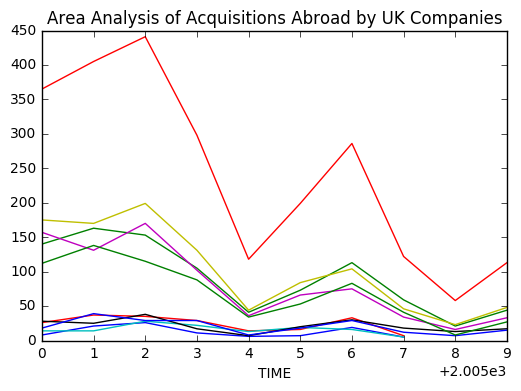

In [18]:
# alternatively, using pivot table (made by Peter)
import pandas as pd
df = ( 
    pd.DataFrame.from_records(mallvalues)
    .rename(columns={-6:"MEASURETYPE", -2:"TIME", -9:"OBS"})
    .assign(TIME=lambda df:df.TIME.astype(int))
    #.assign(TIME2=lambda df:df.TIME.astype(int)*2)
)

pdf = df.pivot_table("OBS", ["TIME"], ["Mergers", "MEASURETYPE", "Area"])
# ["Area Analysis of Acquisitions Abroad by UK Companies"].xs("Number", level="MEASURETYPE", axis=1).plot()
acqtypes = pdf.columns.get_level_values(0).unique()
valtypes = pdf.columns.get_level_values(1).unique()

acqtype = acqtypes[0]
valtype = valtypes[0]
pdf[acqtype][valtype].plot(legend=False, title=acqtype)


In [43]:

# this does the dereferencing into the list of dicts
tab, dimensions, segment = conversionsegments[-1]
obslist = list(segment.unordered_cells)  # list(segment) otherwise gives bags of one element
dimvalues = [ batchcelllookup(tab, obslist, dimension)  for dimension in dimensions ]
#dtuples = zip(*([obslist]+dimvalues))
#keys = [OBS] + [ dimension[1]  for dimension in dimensions ]
#dvalues = [ dict(zip(keys, dtup))  for dtup in dtuples ]
#dvalues[:5]




'{"7 21":[7,2,7,3,1,18,1,21],"12 25":[12,2,12,3,1,18,1,25],"9 36":[7,2,9,3,1,18,1,36],"14 19":[12,2,14,3,1,18,1,19],"7 10":[7,2,7,3,1,4,1,10],"7 16":[7,2,7,3,1,4,1,16],"7 12":[7,2,7,3,1,4,1,12],"14 7":[12,2,14,3,1,4,1,7],"7 14":[7,2,7,3,1,4,1,14],"9 7":[7,2,9,3,1,4,1,7],"12 15":[12,2,12,3,1,4,1,15],"9 37":[7,2,9,3,1,18,1,37],"4 7":[2,2,4,3,1,4,1,7],"4 9":[2,2,4,3,1,4,1,9],"14 34":[12,2,14,3,1,18,1,34],"7 9":[7,2,7,3,1,4,1,9],"4 22":[2,2,4,3,1,18,1,22],"9 33":[7,2,9,3,1,18,1,33],"12 13":[12,2,12,3'

In [50]:
# HTML preview of the dimensions and table (will be moved to a function in databakersolo)

from IPython.display import display
from IPython.core.display import HTML
import databaker.constants
OBS = databaker.constants.OBS

# copied out again
def create_colourlist():
    # Function to dynamically assign colours to dimensions for preview
    "https://github.com/python-excel/xlwt/blob/master/xlwt/Style.py#L309"
    colours = ["lavender", "violet", "gray25", "sea_green",
              "pale_blue", "blue", "gray25", "rose", "tan", "light_yellow", "light_green", "light_turquoise",
              "light_blue", "sky_blue", "plum", "gold", "lime", "coral", "periwinkle", "ice_blue", "aqua"]
    numbers = []
    for i in range(len(databaker.constants.template.dimension_names)-1, \
                   -(len(colours) - len(databaker.constants.template.dimension_names)), -1):
        numbers.append(-i)
    colourlist = dict(list(zip(numbers, colours)))
    return colourlist
colourlist = create_colourlist()
colchange = {"rose":"misty_rose", "ice_blue":"cornflower_blue", "periwinkle":"burly_wood", "pale_blue":"deep_sky_blue", "gray25":"light_gray", "light_turquoise":"pale_turquoise"}


def tsubsets(headers, segment):
    tsubs = [ ]
    if segment:
        tsubs.append((OBS, "OBS", segment))
    for i, header in headers.items():
        if header.direction is not None:   # filter out TempValue headers
            label = header.Dlabel
            if isinstance(label, int) and label < 0:
                label = databaker.constants.template.dimension_names[len(databaker.constants.template.dimension_names)-1+label]
            tsubs.append((i, label, header.bag))
    return tsubs

def dsubsets(dimensions, segment):
    tsubs = [ ]
    if segment:
        tsubs.append((OBS, "OBS", segment))
    for i, (header_bag, label, strict, direction) in enumerate(dimensions):
        if direction is not None:   # filter out TempValue headers
            if isinstance(label, int) and label < 0:
                label = databaker.constants.template.dimension_names[len(databaker.constants.template.dimension_names)-1+label]
            tsubs.append((i, label, header_bag))
    return tsubs


ndividNUM = 1000
dividNUM = "kkkk"
def incrementdividNUM():
    global ndividNUM, dividNUM
    ndividNUM += 1
    dividNUM = "injblock%d" % ndividNUM

def ddtabletohtml(tab, tsubs):
    key = [ ]
    key.append('Table: ')
    key.append('<b>')
    key.append(tab.name); 
    key.append('</b> ')
    key.append('<table class="exkey">\n')
    key.append('<tr>')
    ixyheaderlookup = { }
    for i, label, bag in tsubs:
        for h in bag:
            ixyheaderlookup[(h.x, h.y)] = i
        key.append('<td class="exc%d">' % i)
        key.append(label)
        key.append('</td>')
    key.append('</tr>')
    key.append('</table>\n')
    
    sty = [ ]
    sty.append("<style>\n")
    sty.append("table.ex td, table.ex tr { border: none }\n")
    sty.append("td.exbold { font-weight: bold }\n")
    sty.append("td.exnumber { color: green }\n")
    sty.append("td.exdate { color: purple }\n")
    sty.append("table { border-collapse: collapse }\n")
    for i, col in colourlist.items():
        sty.append("td.exc%d { background-color: %s }\n" % (i, "".join(lv.capitalize() for lv in colchange.get(col, col).split("_"))))
    sty.append("table.ex td:hover { border: thin blue solid }\n")
    sty.append("table.ex td.exc%d:hover { border: thin red solid }\n" % OBS)
    sty.append("</style>\n\n")

    htm = [ ]
    htm.append('<table class="ex">\n')
    for row in tab.rows():
        htm.append("<tr>")
        assert len(row) == tab._max_x + 1
        rrow = sorted(row, key=lambda X: X.x)
        for c in rrow:
            cs = [ ]
            ih = ixyheaderlookup.get((c.x, c.y))
            if ih is not None:             cs.append("exc%d" % ih)
            if c.properties.get_bold():    cs.append("exbold")
            if c.is_date():                cs.append("exdate")
            if c.is_number():              cs.append("exnumber")
            htm.append('<td class="%s" title="%d %d">' % (" ".join(cs), c.x, c.y))
            htm.append(str(c.value))
            htm.append("</td>")
        htm.append("</tr>\n")
    htm.append("</table>\n")

    jsty = "".join(sty)
    jkey = "".join(key)
    jhtm = "".join(htm)
    return "%s\n%s\n%s\n" % (jsty, jkey, jhtm)

jscode = """
<script>
var jslookup = %s; 
var jdividNUM = "%s"; 
var Dclickedcell = null; 
function clickedcell() 
{ 
    Dclickedcell = this; 
    console.log("jjjj", this); 
    var dimpairs = jslookup[this.title]; 
    if (dimpairs !== undefined) {
    
    }
}
Array.prototype.forEach.call(document.querySelectorAll("div#"+jdividNUM+" table.ex td"), function(item, i) { item.onclick=clickedcell; }); 
</script>
"""

def inlinehtmldisplay(htm, hide=False):
    display(HTML('%s: <div id="%s" style="%s">%s</div>' % (dividNUM, dividNUM, "display:none" if hide else "display:inline", htm)))

def inlinehtmljsactive(conversionsegment):
    # generate the lookup table from titles to references
    tab, dimensions, segment = conversionsegment
    obslist = list(segment.unordered_cells)  # list(segment) otherwise gives bags of one element
    dimvalues = [ batchcelllookup(tab, obslist, dimension)  for dimension in dimensions ]
    jslookup = '{%s}' % ",".join('"%d %d":[%s]' % (k.x, k.y, ",".join("%d,%d" % (d.x, d.y)  for d in tup))  \
                           for k, tup in zip(obslist, zip(*dimvalues)))
    display(HTML(jscode % (jslookup, dividNUM)))
    
# could do this as a save and reload
def sidewindowhtmldisplay():
    sjs = '''
<script type="text/Javascript">
var injblock = document.getElementById("%s"); 
console.log(injblock.innerHTML); 
var sidewin = window.open("", "abc123", "toolbar=no,location=no,directories=no,status=no,menubar=no,scrollbars=yes,resizable=yes,width=780,height=200,top=200,left=200"); 
if (sidewin) 
    sidewin.document.body.innerHTML = injblock.innerHTML;
else
    alert("sidewindow didn't work"); 
</script>
'''
    display(HTML(sjs % dividNUM))
    
    


In [51]:
# Preview a conversion segment inline or on second screen 
#from databaker.jupybakeutils import dsubsets, tabletohtml, sidewindowhtmldisplay, inlinehtmldisplay, incrementdividNUM
conversionsegment = conversionsegments[10]
tab, dimensions, segment = conversionsegment
htmtable = ddtabletohtml(tab, dsubsets(dimensions, segment))

incrementdividNUM()
inlinehtmldisplay(htmtable, hide=False)
inlinehtmljsactive(conversionsegment)
#sidewindowhtmldisplay()
#document.getElementsByClassName()
